Будем использовать датасет telecom_dataset.csv
https://code.s3.yandex.net/datasets/telecom_dataset.csv

user_id — идентификатор клиентского аккаунта в сервисе;
date — дата статистики;
direction — направление вызовов (out - исходящий вызов, in — входящий вызов);
internal — является ли звонок внутренним звонком между операторами клиента;
operator_id — идентификатор оператора;
is_missed_call — является ли звонок пропущенным;
calls_count — количество звонков;
call_duration — длительность звонка (без учета времени ожидания);
total_call_duration — длительность звонка (с учетом времени ожидания).

In [12]:
import pandas as pd
import numpy as np
df = pd.read_csv('telecom_dataset.csv')
df['date'] = pd.to_datetime(df['date'])


In [13]:
df.shape

(53902, 9)

In [14]:
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


Мы будем рассматривать данные за 3 месяца

In [15]:
start_date = '2019-09-01'
end_date = '2019-12-31'
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
df.head()


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
118,166377,2019-09-02 00:00:00+03:00,in,False,880028.0,False,2,66,75
119,166377,2019-09-02 00:00:00+03:00,in,False,880026.0,False,1,31,34
120,166377,2019-09-02 00:00:00+03:00,out,False,880026.0,False,16,1853,1983
121,166377,2019-09-02 00:00:00+03:00,out,False,880026.0,True,6,0,168
122,166377,2019-09-02 00:00:00+03:00,out,False,880028.0,False,20,2529,2687


In [16]:
df.shape

(51865, 9)

Далее удобно сгруппировать данные по неделям.

In [17]:
df['year_week'] = df['date'].dt.strftime('%Y-%U') 
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,year_week
118,166377,2019-09-02 00:00:00+03:00,in,False,880028.0,False,2,66,75,2019-35
119,166377,2019-09-02 00:00:00+03:00,in,False,880026.0,False,1,31,34,2019-35
120,166377,2019-09-02 00:00:00+03:00,out,False,880026.0,False,16,1853,1983,2019-35
121,166377,2019-09-02 00:00:00+03:00,out,False,880026.0,True,6,0,168,2019-35
122,166377,2019-09-02 00:00:00+03:00,out,False,880028.0,False,20,2529,2687,2019-35


In [18]:
weekly = (df.groupby(['user_id', 'year_week'], as_index=False).agg({'call_duration': 'sum',  'is_missed_call': 'sum'}))
weekly['missed_flag'] = (weekly['is_missed_call'] > 0).astype(int)
weekly.head()


,user_id,year_week,call_duration,is_missed_call,missed_flag
0,166377,2019-35,22365,22,1
1,166377,2019-36,21592,23,1
2,166377,2019-37,21062,18,1
3,166377,2019-38,28715,18,1
4,166377,2019-39,15124,14,1


In [19]:
weekly['missed_flag'].mean()

0.9201171058134672

Посмотрим на распределения как они изменяются от недели к неделе, для начала посмтроим гистограммы непрерывной метрики


c:\Users\artem\OneDrive\Рабочий стол\модели машинного обучения\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\artem\OneDrive\Рабочий стол\модели машинного обучения\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\artem\OneDrive\Рабочий стол\модели машинного обучения\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\artem\OneDrive\Рабочий стол\модели машинного обучения\.venv\L

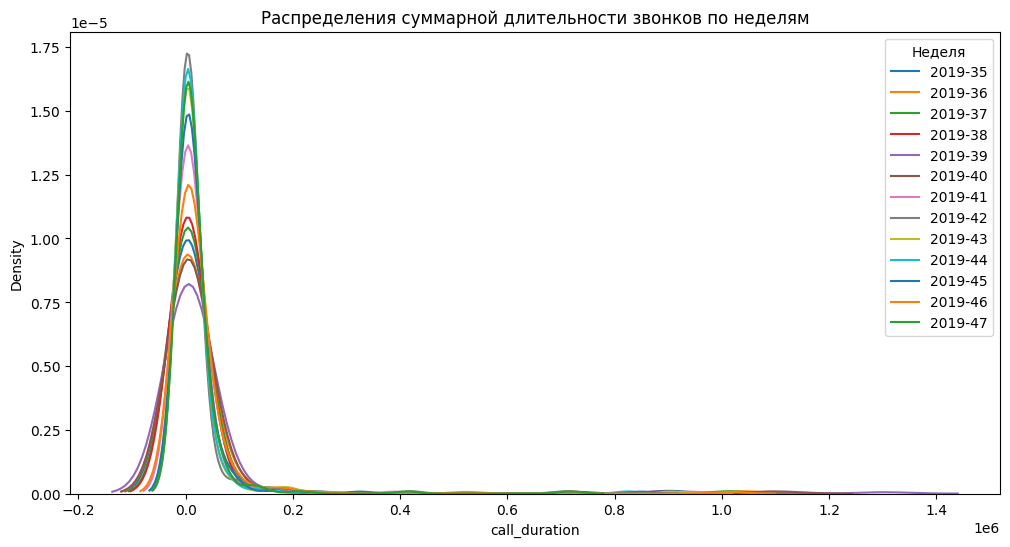

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Обрабатываем NaN и inf значения
weekly_cleaned = weekly[~weekly['call_duration'].isin([float('inf'), -float('inf')])]  # Убираем inf
weekly_cleaned = weekly_cleaned[~weekly_cleaned['call_duration'].isna()]  # Убираем NaN
weekly_cleaned['call_duration'] = weekly_cleaned['call_duration'].replace([float('inf'), -float('inf')], np.nan)
weekly_cleaned['call_duration'] = weekly_cleaned['call_duration'].fillna(weekly_cleaned['call_duration'].median())

unique_weeks = sorted(weekly_cleaned['year_week'].unique())

plt.figure(figsize=(12, 6))

# График KDE для каждой недели
for w in unique_weeks:
    subset = weekly_cleaned[weekly_cleaned['year_week'] == w]
    sns.kdeplot(subset['call_duration'], label=w, fill=False)  # Используем fill вместо shade

plt.title('Распределения суммарной длительности звонков по неделям')
plt.legend(title='Неделя')
plt.show()


Заметим, что все графики довольно схожи, нет сильных отличий, проверим мы эту догадку статистическим тестом Колмогорова-Смирнова

In [19]:
from scipy.stats import ks_2samp

weeks = sorted(weekly['year_week'].unique())

for i in range(len(weeks) - 1):
    w1 = weeks[i]
    w2 = weeks[i+1]
    data1 = weekly[weekly['year_week'] == w1]['call_duration']
    data2 = weekly[weekly['year_week'] == w2]['call_duration']
    
    stat, p_value = ks_2samp(data1, data2)
    print(f'Сравнение {w1} vs {w2}: KS-stat={stat:.3f}, p-value={p_value:.3f}')


Сравнение 2019-35 vs 2019-36: KS-stat=0.079, p-value=0.864
Сравнение 2019-36 vs 2019-37: KS-stat=0.054, p-value=0.991
Сравнение 2019-37 vs 2019-38: KS-stat=0.107, p-value=0.375
Сравнение 2019-38 vs 2019-39: KS-stat=0.069, p-value=0.812
Сравнение 2019-39 vs 2019-40: KS-stat=0.056, p-value=0.931
Сравнение 2019-40 vs 2019-41: KS-stat=0.054, p-value=0.915
Сравнение 2019-41 vs 2019-42: KS-stat=0.049, p-value=0.940
Сравнение 2019-42 vs 2019-43: KS-stat=0.042, p-value=0.978
Сравнение 2019-43 vs 2019-44: KS-stat=0.044, p-value=0.970
Сравнение 2019-44 vs 2019-45: KS-stat=0.061, p-value=0.765
Сравнение 2019-45 vs 2019-46: KS-stat=0.108, p-value=0.132
Сравнение 2019-46 vs 2019-47: KS-stat=0.055, p-value=0.872


Заметим, что в каждом нашем сравнении p_value >= 0.05 следовательно можно говорить, что значимых отличий не обнаруженно

Далее сравним пропорцию (долю 1) между неделями. Допустим, берём те же соседние недели. В Python можно использовать, например, тест на доли (z-тест). Либо вручную посчитать доверительные интервалы и сравнить их

In [20]:
import math

def proportion_test(count1, nobs1, count2, nobs2, alpha=0.05):
    p1 = count1 / nobs1
    p2 = count2 / nobs2
    p = (count1 + count2) / (nobs1 + nobs2) 
    numerator = p1 - p2
    denominator = math.sqrt(p * (1 - p) * (1/nobs1 + 1/nobs2))
    z_stat = numerator / denominator
    # двусторонний p-value
    import mpmath as mp
    p_val = 2 * (1 - 0.5*(1 + math.erf(abs(z_stat)/math.sqrt(2))))
    return z_stat, p_val

weeks = sorted(weekly['year_week'].unique())

for i in range(len(weeks) - 1):
    w1 = weeks[i]
    w2 = weeks[i+1]
    subset1 = weekly[weekly['year_week'] == w1]
    subset2 = weekly[weekly['year_week'] == w2]

    count1 = subset1['missed_flag'].sum() 
    nobs1 = subset1['missed_flag'].shape[0]
    count2 = subset2['missed_flag'].sum()
    nobs2 = subset2['missed_flag'].shape[0]

    z_stat, p_value = proportion_test(count1, nobs1, count2, nobs2)
    print(f'Сравнение пропорций {w1} vs {w2}: Z={z_stat:.3f}, p-value={p_value:.3f}')


Сравнение пропорций 2019-35 vs 2019-36: Z=1.565, p-value=0.118
Сравнение пропорций 2019-36 vs 2019-37: Z=-0.765, p-value=0.444
Сравнение пропорций 2019-37 vs 2019-38: Z=0.508, p-value=0.612
Сравнение пропорций 2019-38 vs 2019-39: Z=-0.107, p-value=0.914
Сравнение пропорций 2019-39 vs 2019-40: Z=0.395, p-value=0.693
Сравнение пропорций 2019-40 vs 2019-41: Z=0.501, p-value=0.616
Сравнение пропорций 2019-41 vs 2019-42: Z=-0.484, p-value=0.628
Сравнение пропорций 2019-42 vs 2019-43: Z=-0.423, p-value=0.672
Сравнение пропорций 2019-43 vs 2019-44: Z=1.102, p-value=0.270
Сравнение пропорций 2019-44 vs 2019-45: Z=-0.236, p-value=0.813
Сравнение пропорций 2019-45 vs 2019-46: Z=-0.214, p-value=0.831
Сравнение пропорций 2019-46 vs 2019-47: Z=0.228, p-value=0.820


Снова получилось что все значения p_value > 0.05 следовательно можно говорить о незначительных отличиях  доли пользователей с пропущенными звонками в зависимости от недели 

Для непрерывной метрики использовали Kolmogorov–Smirnov тест (KS-тест), чтобы проверить, изменяются ли распределения суммарной длительности звонков между неделями. Мы поняли что пользователи ведут себя стабильно, нет никаких серьезных изменений